<a href="https://colab.research.google.com/github/tpiedrahita-byte/sys2025/blob/main/ACF_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Universidad Nacional de Colombia  
## Facultad de Ingeniería  
### Asignatura: Teoría de Señales  

---

# Comparación de Métodos de Estimación de la Función de Autocorrelación (ACF)

---

**Estudiante:**  
Thomas Piedrahita Jaramillo  

**Curso:**  
Teoría de Señales  

**Docente:**  
Cesar German Castellanos Dominguez




---

Manizales, Colombia

# Función de Autocorrelación y Modelo de Referencia

##  Definición de la Función de Autocorrelación

Sea $X[n]$ un proceso aleatorio discreto en el tiempo.  
La **función de autocorrelación teórica** se define como:

$$
R_X[k] \triangleq \mathbb{E}\{X[n]X^*[n+k]\}
$$

Si el proceso es **estacionario en sentido amplio (WSS)**, entonces:

- $\mathbb{E}\{X[n]\} = \mu$ es constante  
- $R_X[k]$ depende únicamente del desfase $k$

En tal caso,

$$
R_X[k] = \mathbb{E}\{X[n]X^*[n+k]\}
$$

es independiente del instante $n$.

La ACF cuantifica la dependencia estadística de segundo orden entre muestras separadas por un desfase $k$ y caracteriza completamente la estructura de correlación del proceso en el caso gaussiano.

---

## Modelo Teórico: Ruido Blanco Gaussiano

En este cuaderno se utilizará como señal de referencia un proceso de **ruido blanco gaussiano (WGN)** definido como:

$$
X[n] \sim \mathcal{N}(0,\sigma^2)
$$

con:

- Media cero: $\mathbb{E}\{X[n]\}=0$  
- Varianza constante: $\mathbb{E}\{X^2[n]\}=\sigma^2$  
- Independencia temporal

Su autocorrelación teórica es:

$$
R_X[k] = \sigma^2 \delta[k]
$$

donde $\delta[k]$ es el delta discreto:

$$
\delta[k] =
\begin{cases}
1, & k=0 \\
0, & k\neq 0
\end{cases}
$$

Esto implica que el proceso no presenta correlación para $k \neq 0$.

---

En las secciones siguientes se presentarán distintos métodos para estimar la función de autocorrelación a partir de una realización finita del proceso.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 1) Gaussian noise definition
# -----------------------------
rng = np.random.default_rng(12345)

N = 4096            # number of samples
sigma = 1.0         # std dev
x = sigma * rng.standard_normal(N)  # real-valued white Gaussian noise

# Theoretical ACF for WGN: R[k] = sigma^2 * delta[k]
# so: R[0] = sigma^2, R[k!=0] = 0


## 1) Estimador Directo en el Dominio del Tiempo (Sesgado)

**Modelo / Estimador**
$$\hat{R}_b[k] \triangleq \frac{1}{N}S[k] = \frac{1}{N}\sum_{n=0}^{N-1-k} x[n]x^*[n+k], \quad k=0,\dots,N-1$$

**Esperanza (Sesgo) bajo WSS**
$$\mathbb{E}\{\hat{R}_b[k]\} = \left(1-\frac{k}{N}\right) R[k]$$

**Notas**
* El factor de sesgo $(1-k/N)$ se debe a la reducción de términos en desfases grandes.

* Preferido en DSP porque garantiza una matriz de correlación **definida positiva**.

---

## 1.2) Estimador Directo en el Dominio del Tiempo (Insesgado)

**Modelo / Estimador**
$$\hat{R}_u[k] \triangleq \frac{1}{N-k}S[k] = \frac{1}{N-k}\sum_{n=0}^{N-1-k} x[n]x^*[n+k], \quad k=0,\dots,N-1$$

**Esperanza bajo WSS**
$$\mathbb{E}\{\hat{R}_u[k]\} = R[k]$$

**Notas**
* Insesgado, pero con mayor varianza para $k$ grandes (menos datos promediados).
* Puede no producir una secuencia definida positiva.

---

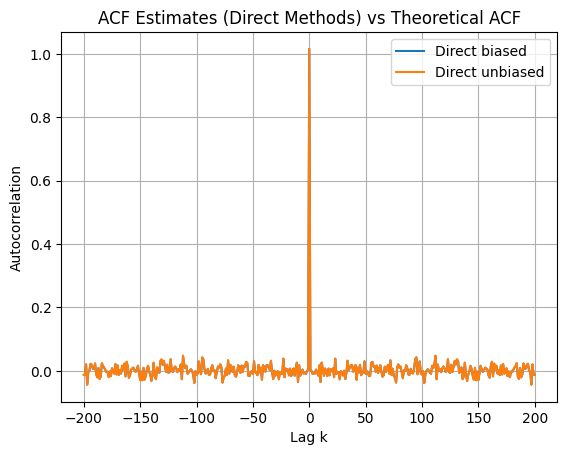

In [2]:
# -------------------------------------------------------
# 1) Direct ACF estimation (biased and unbiased)
#    We compute ACF for lags k = -L,...,0,...,+L
# -------------------------------------------------------
L = 200  # max lag to display (choose smaller to see detail)

# Compute positive-lag raw sums S[k] = sum_{n=0}^{N-1-k} x[n] x[n+k]
# We'll do this in a simple loop for clarity (L is small, so it's fast).
S = np.empty(L + 1, dtype=float)

for k in range(L + 1):
    S[k] = np.dot(x[:N - k], x[k:])  # dot product = sum(x[n]*x[n+k])

# Biased estimator: divide by N
R_b_pos = S / N

# Unbiased estimator: divide by (N-k)
R_u_pos = S / (N - np.arange(L + 1))

# Build full lag sequences using symmetry (real signal => even ACF approximately)
lags = np.arange(-L, L + 1)

# For real signals: R[-k] = R[+k]
R_b = np.concatenate((R_b_pos[:0:-1], R_b_pos))
R_u = np.concatenate((R_u_pos[:0:-1], R_u_pos))

# Theoretical ACF on this lag window
R_theory = np.zeros_like(lags, dtype=float)
R_theory[lags == 0] = sigma**2

# -----------------------------
# Plot (continuous, not stem)
# -----------------------------
plt.figure()
plt.plot(lags, R_b, label="Direct biased")
plt.plot(lags, R_u, label="Direct unbiased")
#plt.plot(lags, R_theory, label="Theoretical (WGN)")
plt.title("ACF Estimates (Direct Methods) vs Theoretical ACF")
plt.xlabel("Lag k")
plt.ylabel("Autocorrelation")
plt.grid(True)
plt.legend()
plt.show()


## Estimación de la ACF mediante FFT (con zero-padding)

Sea una realización finita $x[0],\dots,x[N-1]$.  
La suma de autocorrelación aperiódica es:

$$
S[k] = \sum_{n=0}^{N-1-k} x[n]x^*[n+k]
$$

y el estimador sesgado:

$$
\hat R_b[k] = \frac{1}{N} S[k].
$$

---

### Método basado en FFT

Para calcular $S[k]$ eficientemente:

1. Elegir $M \ge 2N$ (para evitar correlación circular).
2. Construir $x_M[n]$ extendiendo con ceros hasta longitud $M$.
3. Calcular la DFT:

$$
X[m] = \mathrm{FFT}\{x_M[n]\}
$$

4. Formar el espectro de potencia discreto:

$$
|X[m]|^2 = X[m]X^*[m]
$$

5. Aplicar IFFT:

$$
r[k] = \mathrm{IFFT}\{|X[m]|^2\}
$$

Si $M \ge 2N$, entonces:

$$
r[k] = S[k], \quad k=0,\dots,N-1.
$$

Por tanto, el estimador FFT sesgado es:

$$
\hat R_{\text{FFT},b}[k] = \frac{1}{N} r[k].
$$

---




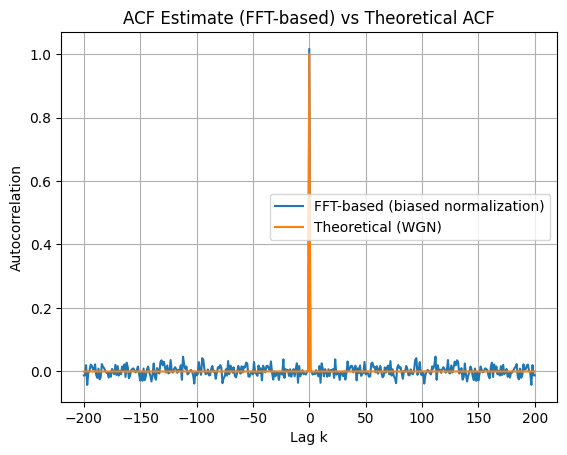

In [3]:
# -------------------------------------------------------
# 2) FFT-based ACF estimation (aperiodic via zero-padding)
# -------------------------------------------------------
# Choose M >= 2N to avoid circular correlation wrap-around.
M = 1 << int(np.ceil(np.log2(2 * N)))  # next power of 2 >= 2N

# Zero-pad x to length M
x_pad = np.zeros(M, dtype=float)
x_pad[:N] = x

# FFT -> power spectrum -> IFFT
X = np.fft.fft(x_pad)
r_circ = np.fft.ifft(np.abs(X)**2).real  # should be real for real x

# r_circ[0:L] corresponds to lags 0..L (aperiodic part due to padding)
S_fft = r_circ[:L + 1]  # raw sums S[k] (same idea as direct dot products)

# Normalize to match biased estimator (divide by N)
R_fft_biased_pos = S_fft / N

# Build full lags using symmetry
R_fft_biased = np.concatenate((R_fft_biased_pos[:0:-1], R_fft_biased_pos))

# Theoretical ACF on this lag window
R_theory = np.zeros_like(lags, dtype=float)
R_theory[lags == 0] = sigma**2

# -----------------------------
# Plot (continuous, not stem)
# -----------------------------
plt.figure()
plt.plot(lags, R_fft_biased, label="FFT-based (biased normalization)")
plt.plot(lags, R_theory, label="Theoretical (WGN)")
plt.title("ACF Estimate (FFT-based) vs Theoretical ACF")
plt.xlabel("Lag k")
plt.ylabel("Autocorrelation")
plt.grid(True)
plt.legend()
plt.show()


## Estimación Paramétrica de la ACF mediante AR(p) (Yule–Walker)

### Modelo AR(p)

Se asume que el proceso sigue un modelo autorregresivo de orden $p$:

$$
X[n] = \sum_{i=1}^{p} a_i X[n-i] + W[n]
$$

donde $W[n]$ es ruido blanco con varianza $\sigma_w^2$.

---

### Ecuaciones de Yule–Walker

Para un proceso WSS, la ACF satisface:

$$
R[k] = \sum_{i=1}^{p} a_i R[k-i], \quad k \ge 1
$$

y para $k=0$:

$$
R[0] = \sum_{i=1}^{p} a_i R[i] + \sigma_w^2
$$

En forma matricial (sistema Toeplitz):

$$
\underbrace{
\begin{bmatrix}
R[0] & R[1] & \cdots & R[p-1] \\
R[1] & R[0] & \cdots & R[p-2] \\
\vdots & \vdots & \ddots & \vdots \\
R[p-1] & R[p-2] & \cdots & R[0]
\end{bmatrix}
}_{T_p}
\begin{bmatrix}
a_1 \\
a_2 \\
\vdots \\
a_p
\end{bmatrix}
=
\begin{bmatrix}
R[1] \\
R[2] \\
\vdots \\
R[p]
\end{bmatrix}
$$

---

### Procedimiento de Estimación

1. Estimar $\hat R[0],\dots,\hat R[p]$ (usualmente con el estimador sesgado).
2. Resolver el sistema:

$$
\hat T_p \hat a = \hat r
$$

3. Estimar la varianza de innovación:

$$
\hat\sigma_w^2 = \hat R[0] - \sum_{i=1}^{p} \hat a_i \hat R[i]
$$

4. Generar la ACF paramétrica recursivamente:

$$
\hat R_{\text{AR}}[k] = \sum_{i=1}^{p} \hat a_i \hat R_{\text{AR}}[k-i], \quad k \ge 1
$$

---

### Características

- Produce una ACF suave y consistente con el modelo asumido.
- Reduce varianza respecto a métodos no paramétricos.
- Depende críticamente del orden $p$.


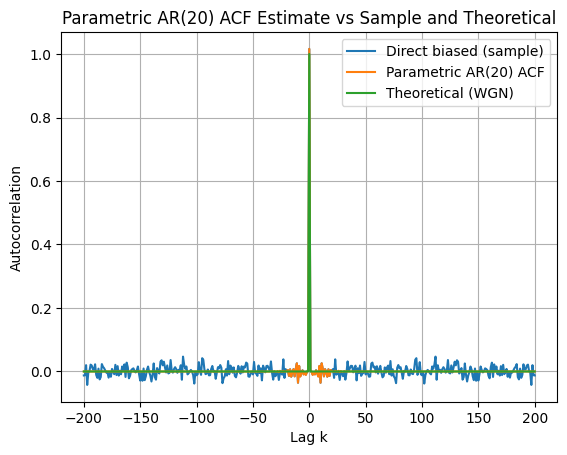

Estimated AR coefficients a_i:
[ 0.00582803 -0.00131633 -0.01068845 -0.00482722 -0.00946705  0.00359371
 -0.0043755  -0.01623524  0.01783745 -0.0358086   0.02528191  0.00742937
 -0.01634469  0.00793653 -0.00210942 -0.01587546  0.00714293 -0.01560309
  0.0066373  -0.00013932]
Estimated innovation variance sigma_w^2: 1.0123397592061227


In [4]:
# -------------------------------------------------------
# 4) Parametric ACF estimation via AR(p) (Yule–Walker)
# Uses the same x, N, sigma, L from previous blocks.
# If you're running this standalone, re-define x, N, sigma, L.
# -------------------------------------------------------

p = 20  # AR model order (try 5, 10, 20; for white noise, true is ~0)

# Step A: Estimate autocorrelation needed for Yule–Walker.
# Common choice: biased ACF estimates for Toeplitz PSD stability.
R0_to_p = np.empty(p + 1, dtype=float)
for k in range(p + 1):
    R0_to_p[k] = np.dot(x[:N - k], x[k:]) / N  # biased normalization

# Build Toeplitz matrix T_p from R[0..p-1]
# T[i,j] = R[|i-j|], i,j = 0..p-1
T = np.empty((p, p), dtype=float)
for i in range(p):
    for j in range(p):
        T[i, j] = R0_to_p[abs(i - j)]

# Right-hand side vector r = [R[1],...,R[p]]
r = R0_to_p[1:p+1].copy()

# Step B: Solve Yule–Walker for AR coefficients a
# T a = r
# If T is near-singular, lstsq is more robust than solve.
a, *_ = np.linalg.lstsq(T, r, rcond=None)

# Step C: Estimate innovation variance sigma_w^2 (from k=0 equation)
sigma_w2 = R0_to_p[0] - np.dot(a, R0_to_p[1:p+1])

# Step D: Generate parametric ACF up to lag L using the AR recursion
R_ar_pos = np.zeros(L + 1, dtype=float)
R_ar_pos[0] = R0_to_p[0]  # anchor with estimated R[0]

# For k=1..L:
# R[k] = sum_{i=1..p} a_i R[k-i], using R[negative] = R[positive] symmetry
for k in range(1, L + 1):
    acc = 0.0
    for i in range(1, p + 1):
        idx = k - i
        if idx >= 0:
            acc += a[i - 1] * R_ar_pos[idx]
        else:
            # For a real WSS process: R[-m] = R[m]
            acc += a[i - 1] * R_ar_pos[-idx]
    R_ar_pos[k] = acc

# Build full lags via symmetry
lags = np.arange(-L, L + 1)
R_ar = np.concatenate((R_ar_pos[:0:-1], R_ar_pos))

# Theoretical ACF for WGN
R_theory = np.zeros_like(lags, dtype=float)
R_theory[lags == 0] = sigma**2

# Optional: also compare against the direct biased estimate in the same plot
# (recompute quickly for window L)
S = np.empty(L + 1, dtype=float)
for k in range(L + 1):
    S[k] = np.dot(x[:N - k], x[k:])
R_direct_b_pos = S / N
R_direct_b = np.concatenate((R_direct_b_pos[:0:-1], R_direct_b_pos))

# -----------------------------
# Plot (continuous)
# -----------------------------
plt.figure()
plt.plot(lags, R_direct_b, label="Direct biased (sample)")
plt.plot(lags, R_ar, label=f"Parametric AR({p}) ACF")
plt.plot(lags, R_theory, label="Theoretical (WGN)")
plt.title(f"Parametric AR({p}) ACF Estimate vs Sample and Theoretical")
plt.xlabel("Lag k")
plt.ylabel("Autocorrelation")
plt.grid(True)
plt.legend()
plt.show()

# Print estimated AR coefficients magnitude (should be near 0 for WGN)
print("Estimated AR coefficients a_i:")
print(a)
print("Estimated innovation variance sigma_w^2:", sigma_w2)


## Estimación Recursiva de la ACF (EWMA / Forgetting Factor)

Sea una secuencia $x[n]$ observada en streaming.  
La autocorrelación teórica es:

$$
R[k] = \mathbb{E}\{X[n]X^*[n-k]\}
$$

Para estimarla en línea (online), se utiliza un promedio exponencialmente ponderado:

---

### Estimador Recursivo

Para cada desfase $k = 0,\dots,L$:

$$
\hat R_k[n]
=
\lambda \hat R_k[n-1]
+
(1-\lambda)\,x[n]x^*[n-k],
\qquad 0 < \lambda < 1
$$

donde:

- $\lambda$ es el **factor de olvido**
- $x[n]x^*[n-k]$ es la correlación instantánea

---

### Interpretación

El estimador implementa un filtro IIR de primer orden sobre el producto instantáneo.  
Equivale a un promedio ponderado:

$$
\hat R_k[n]
=
(1-\lambda)
\sum_{m=0}^{\infty}
\lambda^{m}
\,x[n-m]x^*[n-m-k]
$$

---

### Longitud efectiva de memoria

La ventana efectiva aproximada es:

$$
N_{\text{eff}} \approx \frac{1}{1-\lambda}
$$

- $\lambda \to 1$ → mayor suavizado, menor varianza  
- $\lambda$ pequeño → mayor adaptabilidad, mayor varianza  

---




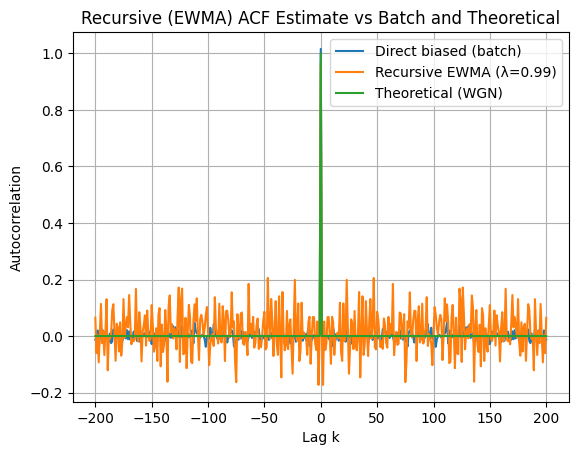

Effective averaging length ~ 100.0 samples
Recursive estimate R_rec_pos[0] (should be ~ sigma^2): 0.9666032540978791


In [5]:
# -------------------------------------------------------
# 5) Recursive ACF estimation (EWMA / forgetting factor)
# Uses the same x, N, sigma, L from previous blocks.
# If running standalone, re-define x, N, sigma, L.
# -------------------------------------------------------

L = 200          # max lag to estimate/display
lam = 0.99       # forgetting factor (0.95..0.999 typical)
# Effective window length ~ 1/(1-lam) = 100 samples for 0.99

# Initialize recursive estimates for lags 0..L
R_rec_pos = np.zeros(L + 1, dtype=float)

# Run recursive updates through the data stream
# Update only when n >= k (otherwise x[n-k] doesn't exist)
for n in range(N):
    xn = x[n]
    # lag 0 update
    R_rec_pos[0] = lam * R_rec_pos[0] + (1 - lam) * (xn * xn)

    # lags 1..L
    kmax = min(L, n)
    for k in range(1, kmax + 1):
        R_rec_pos[k] = lam * R_rec_pos[k] + (1 - lam) * (xn * x[n - k])

# Build full lags by symmetry (real WSS => R[-k]=R[k])
lags = np.arange(-L, L + 1)
R_rec = np.concatenate((R_rec_pos[:0:-1], R_rec_pos))

# Theoretical ACF for WGN
R_theory = np.zeros_like(lags, dtype=float)
R_theory[lags == 0] = sigma**2

# Optional: compare with direct biased estimator on the same lag window
S = np.empty(L + 1, dtype=float)
for k in range(L + 1):
    S[k] = np.dot(x[:N - k], x[k:])
R_direct_b_pos = S / N
R_direct_b = np.concatenate((R_direct_b_pos[:0:-1], R_direct_b_pos))

# -----------------------------
# Plot (continuous)
# -----------------------------
plt.figure()
plt.plot(lags, R_direct_b, label="Direct biased (batch)")
plt.plot(lags, R_rec, label=f"Recursive EWMA (λ={lam})")
plt.plot(lags, R_theory, label="Theoretical (WGN)")
plt.title("Recursive (EWMA) ACF Estimate vs Batch and Theoretical")
plt.xlabel("Lag k")
plt.ylabel("Autocorrelation")
plt.grid(True)
plt.legend()
plt.show()

# Helpful diagnostic
Neff = 1.0 / (1.0 - lam)
print(f"Effective averaging length ~ {Neff:.1f} samples")
print("Recursive estimate R_rec_pos[0] (should be ~ sigma^2):", R_rec_pos[0])


In [26]:
# ============================================================
# CELDA — IMPORTS + DEFINICIÓN DE SEÑAL DE PRUEBA Y ACF TEÓRICA
# ============================================================
# ¿Qué hace esta celda?
# 1) Importa librerías necesarias:
#    - NumPy: arreglos y cálculo numérico
#    - Matplotlib: gráficas
#    - perf_counter: timer de alta resolución (para medir tiempos después)
# 2) Define la señal de prueba para la comparación de métodos ACF:
#    x[n] = A cos(2π f0 n + φ) + w[n], con w[n] ~ N(0, σ^2)
# 3) Define una ACF teórica de referencia para esta señal:
#    R[k] = (A^2/2) cos(2π f0 k) + σ^2 δ[k]
#    (coseno → correlación oscilatoria, ruido blanco → energía extra en k=0)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from time import perf_counter  # Timer para medición experimental de tiempos

# ------------------------------------------------------------
# SEÑAL DE PRUEBA: COSENO + RUIDO BLANCO GAUSSIANO (WGN)
# ------------------------------------------------------------
# Modelo:
#   x[n] = A cos(2π f0 n + φ) + w[n]
#
# Parámetros:
#   - N     : número de muestras
#   - A     : amplitud del coseno (componente determinística)
#   - f0    : frecuencia normalizada (ciclos por muestra)
#   - sigma : desviación estándar del ruido WGN
#   - seed  : semilla para reproducibilidad (mismo experimento si se repite)
#   - phi   : fase del coseno (si es None se elige aleatoria)
# ------------------------------------------------------------
def generate_signal(N, A=1.0, f0=0.06, sigma=0.5, seed=None, phi=None):
    # Generador de números aleatorios (reproducible si seed no es None)
    rng = np.random.default_rng(seed)

    # Índice temporal discreto
    n = np.arange(N)

    # Fase del coseno:
    #   Si no se entrega, se toma aleatoria uniforme en [0, 2π)
    if phi is None:
        phi = 2 * np.pi * rng.random()

    # Componente determinística (coseno)
    x_det = A * np.cos(2 * np.pi * f0 * n + phi)

    # Componente aleatoria: ruido blanco gaussiano
    w = sigma * rng.standard_normal(N)

    # Señal final: determinística + aleatoria
    return x_det + w

# ------------------------------------------------------------
# ACF TEÓRICA DE REFERENCIA (para comparar estimaciones)
# ------------------------------------------------------------
# Modelo típico:
#   - Para el coseno:  (A^2/2) cos(2π f0 k)
#   - Para el ruido:  σ^2 δ[k]  (suma σ^2 solo en k=0)
#
# Entrada:
#   - lags: vector de desfases k (por ejemplo: -L..L)
# Salida:
#   - R: ACF teórica evaluada en esos lags
# ------------------------------------------------------------
def acf_theoretical(lags, A=1.0, f0=0.06, sigma=0.5):
    # Parte determinística: autocorrelación de un coseno
    R = (A**2 / 2) * np.cos(2 * np.pi * f0 * lags)
    R = R.astype(float)

    # Parte aleatoria: contribución del ruido blanco (delta en k=0)
    R[lags == 0] += sigma**2

    return R

In [27]:
# ============================================================
# CELDA — IMPLEMENTACIÓN DE LOS 4 MÉTODOS DE ESTIMACIÓN DE ACF
# ============================================================
# ¿Qué hace esta celda?
#   Define (en funciones separadas) los 4 métodos que se van a comparar:
#
#   (1) Método directo (sesgado e insesgado)
#   (2) Método basado en FFT (sesgado, con zero-padding para correlación aperiódica)
#   (3) Método paramétrico AR(p) usando Yule–Walker
#   (4) Método recursivo EWMA (estimación online con factor de olvido λ)
#
# ¿Qué devuelve cada función?
#   Todas devuelven la ACF en el rango de lags -L..L (misma convención del cuaderno),
#   usando simetría para construir los lags negativos a partir de los positivos.
# ============================================================


# ============================================================
# (1) ACF DIRECTA — SESGADA E INSESGADA (DOMINIO DEL TIEMPO)
# ============================================================
# Idea:
#   Para lags k = 0..L se calcula la suma cruda:
#     S[k] = Σ_{n=0}^{N-1-k} x[n] x[n+k]
#
#   Luego:
#     - Estimador sesgado:   Rb[k] = S[k] / N
#     - Estimador insesgado: Ru[k] = S[k] / (N-k)
#
#   Finalmente se construyen lags negativos usando simetría:
#     R[-k] = R[k]  (señal real / ACF par para WSS real)
# ============================================================
def acf_direct(x, L):
    """Devuelve ACF directa sesgada e insesgada en lags -L..L (como cuaderno)."""
    N = len(x)

    # S[k] almacenará las sumas crudas para k=0..L
    S = np.empty(L + 1, dtype=float)

    # Cálculo explícito de S[k] con productos punto (dot):
    # np.dot(x[:N-k], x[k:]) = Σ x[n]*x[n+k]
    for k in range(L + 1):
        S[k] = np.dot(x[:N - k], x[k:])

    # Normalización para obtener estimadores:
    Rb_pos = S / N                           # sesgado (divide por N fijo)
    Ru_pos = S / (N - np.arange(L + 1))      # insesgado (divide por N-k)

    # Construir secuencia completa -L..L por simetría:
    #   [R(L),...,R(1),R(0),R(1),...,R(L)]
    Rb = np.concatenate((Rb_pos[:0:-1], Rb_pos))
    Ru = np.concatenate((Ru_pos[:0:-1], Ru_pos))

    return Rb, Ru


# ============================================================
# (2) ACF POR FFT — SESGADA (ZERO-PADDING PARA EVITAR WRAP-AROUND)
# ============================================================
# Idea (Wiener–Khinchin discreto):
#   - Zero-padding a longitud M >= 2N para que la correlación circular
#     coincida con la correlación aperiódica (lineal) en los primeros lags.
#   - FFT: X = FFT(x_pad)
#   - Espectro de potencia: |X|^2
#   - IFFT: r = IFFT(|X|^2)  -> produce correlación (circular, pero padding evita aliasing)
#   - Extraer lags 0..L y normalizar sesgado: Rb[k] = r[k]/N
# ============================================================
def acf_fft_biased(x, L):
    """ACF sesgada basada en FFT con zero-padding (como cuaderno)."""
    N = len(x)

    # Elegir M como potencia de 2 >= 2N (rápido para FFT y evita wrap-around)
    M = 1 << int(np.ceil(np.log2(2 * N)))

    # Zero-padding: x_pad tiene N muestras reales y luego ceros hasta M
    x_pad = np.zeros(M, dtype=float)
    x_pad[:N] = x

    # FFT -> potencia -> IFFT
    X = np.fft.fft(x_pad)
    r = np.fft.ifft(np.abs(X)**2).real  # debe ser real para señales reales (imag ~ error numérico)

    # r[0..L] equivale a sumas crudas S[k] (por padding suficiente)
    S_fft = r[:L + 1]

    # Normalización sesgada
    Rb_pos = S_fft / N

    # Construir lags -L..L por simetría
    Rb = np.concatenate((Rb_pos[:0:-1], Rb_pos))

    return Rb


# ============================================================
# (3) ACF PARAMÉTRICA AR(p) — YULE–WALKER
# ============================================================
# Idea:
#   Suponer que el proceso puede aproximarse por un modelo AR(p):
#     X[n] = Σ_{i=1..p} a_i X[n-i] + W[n]
#
#   Procedimiento (como cuaderno):
#   A) Estimar R[0..p] (sesgado) -> estabilidad Toeplitz
#   B) Armar matriz Toeplitz T con T[i,j]=R[|i-j|]
#   C) Resolver Yule–Walker: T a = r, donde r=[R[1],...,R[p]]
#   D) Generar ACF paramétrica por recursión:
#        R[k] = Σ a_i R[k-i]
#      usando simetría cuando k-i es negativo.
# ============================================================
def acf_ar_yw(x, L, p=20):
    """ACF paramétrica vía AR(p) con Yule–Walker (como cuaderno)."""
    N = len(x)

    # ---- A) Estimar R[0..p] con estimador sesgado ----
    R0_to_p = np.empty(p + 1, dtype=float)
    for k in range(p + 1):
        R0_to_p[k] = np.dot(x[:N - k], x[k:]) / N

    # ---- B) Construir matriz Toeplitz T[i,j] = R[|i-j|] ----
    T = np.empty((p, p), dtype=float)
    for i in range(p):
        for j in range(p):
            T[i, j] = R0_to_p[abs(i - j)]

    # ---- C) Vector r = [R[1],...,R[p]] y solución de Yule–Walker ----
    r = R0_to_p[1:p + 1].copy()
    a, *_ = np.linalg.lstsq(T, r, rcond=None)  # lstsq es robusto si T está mal condicionada

    # ---- D) Generar ACF paramétrica hasta lag L ----
    R_ar_pos = np.zeros(L + 1, dtype=float)
    R_ar_pos[0] = R0_to_p[0]  # ancla con R[0] estimado

    for k in range(1, L + 1):
        acc = 0.0
        for i in range(1, p + 1):
            idx = k - i
            if idx >= 0:
                acc += a[i - 1] * R_ar_pos[idx]
            else:
                # Para proceso real WSS: R[-m] = R[m]
                acc += a[i - 1] * R_ar_pos[-idx]
        R_ar_pos[k] = acc

    # Construir lags -L..L por simetría
    R_ar = np.concatenate((R_ar_pos[:0:-1], R_ar_pos))

    return R_ar, a


# ============================================================
# (4) ACF RECURSIVA EWMA — FORGETTING FACTOR (ONLINE)
# ============================================================
# Idea:
#   Estimar la ACF en streaming con promedio exponencial:
#     R_k[n] = λ R_k[n-1] + (1-λ) x[n] x[n-k]
#
#   - Se actualiza para k=0..L
#   - Solo se actualiza k cuando n>=k (para que exista x[n-k])
#   - Al final se construye la ACF completa -L..L por simetría.
# ============================================================
def acf_ewma(x, L, lam=0.99):
    """ACF recursiva EWMA (como cuaderno)."""
    N = len(x)

    # R_pos[k] almacenará la estimación recursiva de R[k] para k=0..L
    R_pos = np.zeros(L + 1, dtype=float)

    # Recorrer muestras como si fuera streaming
    for n in range(N):
        xn = x[n]

        # Actualización para k=0 (producto instantáneo x[n]^2)
        R_pos[0] = lam * R_pos[0] + (1 - lam) * (xn * xn)

        # Actualización para k=1..min(L,n)
        kmax = min(L, n)
        for k in range(1, kmax + 1):
            R_pos[k] = lam * R_pos[k] + (1 - lam) * (xn * x[n - k])

    # Construir lags -L..L por simetría
    R = np.concatenate((R_pos[:0:-1], R_pos))

    return R

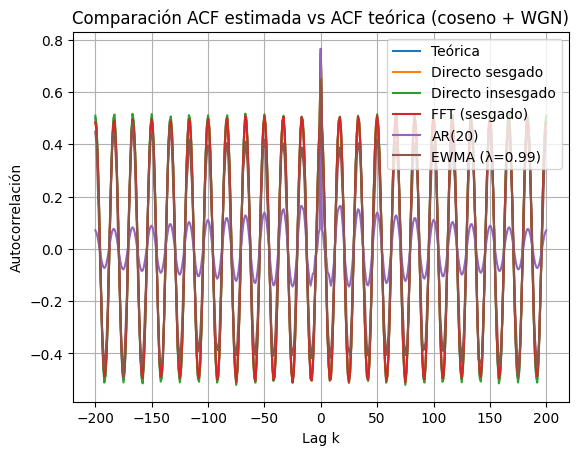

AR coeficientes (primeros 10): [ 0.09840383  0.06563119 -0.00153018 -0.01743734 -0.02873702 -0.09748426
 -0.07819966 -0.08400752 -0.10117981 -0.05957542]
Neff EWMA ~ 99.99999999999991


In [28]:
# ============================================================
# CELDA — COMPARACIÓN GRÁFICA DE LOS 4 MÉTODOS (EJEMPLO CON N FIJO)
# ============================================================
# ¿Qué hace esta celda?
#   1) Define los parámetros del experimento (A, f0, sigma, L, N, p, lam).
#   2) Genera una señal de prueba: coseno + ruido blanco gaussiano (WGN).
#   3) Construye la ACF teórica (referencia) para lags -L..L.
#   4) Calcula la ACF estimada usando los 4 métodos:
#        - Directo (sesgado e insesgado)
#        - FFT (sesgado)
#        - Paramétrico AR(p)
#        - Recursivo EWMA
#   5) Grafica todas las curvas juntas para comparar visualmente.
#   6) Imprime diagnósticos:
#        - primeros coeficientes AR
#        - ventana efectiva de EWMA: Neff ≈ 1/(1-λ)
# ============================================================

# ------------------------------------------------------------
# 1) PARÁMETROS DEL EXPERIMENTO
# ------------------------------------------------------------
A = 1.0          # amplitud del coseno (componente determinística)
f0 = 0.06        # frecuencia normalizada (ciclos/muestra)
sigma = 0.5      # desviación estándar del ruido WGN (componente aleatoria)

L = 200          # máximo desfase (lags: -L..L)
N = 4096         # longitud de la señal (tamaño de muestra)

p = 20           # orden del modelo AR(p)
lam = 0.99       # factor de olvido EWMA

# ------------------------------------------------------------
# 2) GENERAR LA SEÑAL DE PRUEBA (COSENO + RUIDO)
# ------------------------------------------------------------
# Se usa seed para que el experimento sea reproducible.
x = generate_signal(N, A=A, f0=f0, sigma=sigma, seed=123)

# ------------------------------------------------------------
# 3) DEFINIR LAGS Y ACF TEÓRICA (REFERENCIA)
# ------------------------------------------------------------
lags = np.arange(-L, L + 1)
R_th = acf_theoretical(lags, A=A, f0=f0, sigma=sigma)

# ------------------------------------------------------------
# 4) ESTIMAR LA ACF CON LOS 4 MÉTODOS
# ------------------------------------------------------------
# (a) Directo sesgado e insesgado
Rb, Ru = acf_direct(x, L)

# (b) FFT sesgado
Rfft = acf_fft_biased(x, L)

# (c) AR(p) paramétrico (devuelve ACF y coeficientes)
Rar, a_hat = acf_ar_yw(x, L, p=p)

# (d) EWMA recursivo
Rew = acf_ewma(x, L, lam=lam)

# ------------------------------------------------------------
# 5) GRÁFICA COMPARATIVA
# ------------------------------------------------------------
plt.figure()
plt.plot(lags, R_th, label="Teórica")
plt.plot(lags, Rb, label="Directo sesgado")
plt.plot(lags, Ru, label="Directo insesgado")
plt.plot(lags, Rfft, label="FFT (sesgado)")
plt.plot(lags, Rar, label=f"AR({p})")
plt.plot(lags, Rew, label=f"EWMA (λ={lam})")

plt.title("Comparación ACF estimada vs ACF teórica (coseno + WGN)")
plt.xlabel("Lag k")
plt.ylabel("Autocorrelación")
plt.grid(True)
plt.legend()
plt.show()

# ------------------------------------------------------------
# 6) DIAGNÓSTICOS / CHEQUEOS ÚTILES
# ------------------------------------------------------------
# Coeficientes del modelo AR: si el proceso fuera puramente ruido blanco,
# los a_i tenderían a ser cercanos a 0. Aquí hay coseno + ruido, así que
# puede aparecer estructura dependiendo de p.
print("AR coeficientes (primeros 10):", a_hat[:10])

# Ventana efectiva aproximada de EWMA: Neff ≈ 1/(1-λ)
print("Neff EWMA ~", 1 / (1 - lam))

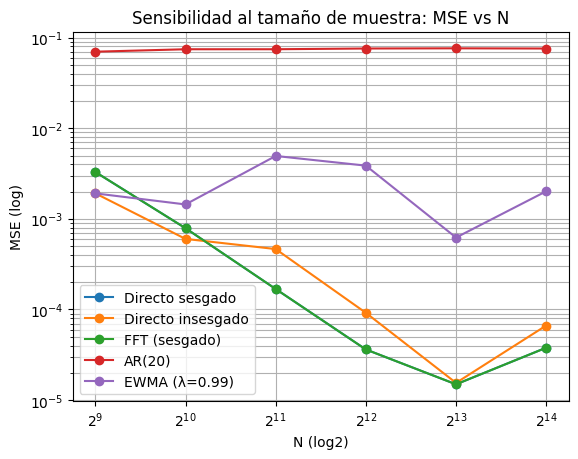

In [29]:
# ============================================================
# CELDA — SENSIBILIDAD AL TAMAÑO DE MUESTRA (MSE vs N)
# ============================================================
# ¿Qué hace esta celda?
#   1) Define una función MSE (Mean Squared Error) para comparar
#      una ACF estimada contra la ACF teórica.
#   2) Evalúa cómo cambia el error (MSE) cuando aumenta el tamaño
#      de muestra N.
#   3) Para cada N:
#        - Genera señal coseno + WGN
#        - Calcula la ACF teórica
#        - Estima la ACF con los 4 métodos
#        - Calcula el MSE respecto a la teórica
#   4) Grafica MSE vs N en escala log–log.
#
# Interpretación esperada:
#   - Al aumentar N, el MSE debería disminuir.
#   - Permite analizar sensibilidad al tamaño de muestra.
# ============================================================


# ------------------------------------------------------------
# FUNCIÓN DE ERROR CUADRÁTICO MEDIO (MSE)
# ------------------------------------------------------------
# MSE(a,b) = promedio de (a-b)^2
# Mide qué tan lejos está la ACF estimada de la teórica.
def mse(a, b):
    return np.mean((a - b)**2)


# ------------------------------------------------------------
# LONGITUDES DE SEÑAL A EVALUAR
# ------------------------------------------------------------
# Se estudia cómo se comportan los métodos al aumentar N.
Ns = [512, 1024, 2048, 4096, 8192, 16384]

# Parámetros del modelo (orden AR y forgetting factor)
p = 20
lam = 0.99

# Listas donde se almacenará el MSE para cada método
mse_direct_b = []
mse_direct_u = []
mse_fft = []
mse_ar = []
mse_ewma = []


# ============================================================
# BUCLE PRINCIPAL: CALCULAR MSE PARA CADA N
# ============================================================
for N in Ns:

    # --------------------------------------------------------
    # 1) Generar señal (misma seed para comparabilidad)
    # --------------------------------------------------------
    x = generate_signal(N, A=A, f0=f0, sigma=sigma, seed=123)

    # Definir lags y ACF teórica de referencia
    lags = np.arange(-L, L + 1)
    R_th = acf_theoretical(lags, A=A, f0=f0, sigma=sigma)

    # --------------------------------------------------------
    # 2) Estimar ACF con los 4 métodos
    # --------------------------------------------------------
    Rb, Ru = acf_direct(x, L)            # Directo
    Rfft = acf_fft_biased(x, L)          # FFT
    Rar, _ = acf_ar_yw(x, L, p=p)        # AR(p)
    Rew = acf_ewma(x, L, lam=lam)        # EWMA

    # --------------------------------------------------------
    # 3) Calcular MSE respecto a la ACF teórica
    # --------------------------------------------------------
    mse_direct_b.append(mse(Rb, R_th))
    mse_direct_u.append(mse(Ru, R_th))
    mse_fft.append(mse(Rfft, R_th))
    mse_ar.append(mse(Rar, R_th))
    mse_ewma.append(mse(Rew, R_th))


# ============================================================
# 4) GRÁFICA: MSE vs N (ESCALA LOG–LOG)
# ============================================================
plt.figure()

plt.plot(Ns, mse_direct_b, marker="o", label="Directo sesgado")
plt.plot(Ns, mse_direct_u, marker="o", label="Directo insesgado")
plt.plot(Ns, mse_fft, marker="o", label="FFT (sesgado)")
plt.plot(Ns, mse_ar, marker="o", label=f"AR({p})")
plt.plot(Ns, mse_ewma, marker="o", label=f"EWMA (λ={lam})")

# Escalas logarítmicas para visualizar tendencia de convergencia
plt.xscale("log", base=2)
plt.yscale("log")

plt.title("Sensibilidad al tamaño de muestra: MSE vs N")
plt.xlabel("N (log2)")
plt.ylabel("MSE (log)")
plt.grid(True, which="both")
plt.legend()
plt.show()

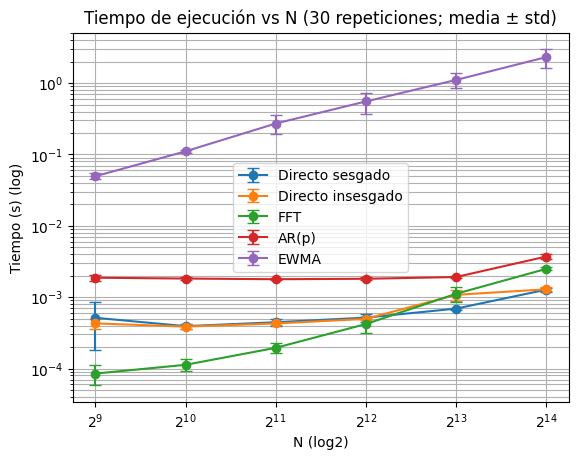

In [30]:
# ============================================================
# CELDA — MEDICIÓN EXPERIMENTAL DEL TIEMPO DE EJECUCIÓN
# ============================================================
# ¿Qué hace esta celda?
#   1) Define una función time_method que mide el tiempo de ejecución
#      de un método de estimación de ACF.
#   2) Para cada tamaño de muestra N:
#         - Genera la señal coseno + WGN
#         - Ejecuta cada método 30 veces
#         - Registra el tiempo promedio (valor esperado experimental)
#           y la desviación estándar
#   3) Grafica tiempo vs N en escala log–log con barras de error.
#
# Esto permite comparar experimentalmente la complejidad real
# de los cuatro métodos.
# ============================================================


# ------------------------------------------------------------
# FUNCIÓN DE MEDICIÓN DE TIEMPO
# ------------------------------------------------------------
# Parámetros:
#   - fn: función que implementa el método de ACF
#   - x: señal de entrada
#   - repeats: número de repeticiones (30 según la tarea)
#
# Devuelve:
#   - tiempo promedio
#   - desviación estándar
# ------------------------------------------------------------
def time_method(fn, x, repeats=30):
    times = np.empty(repeats, dtype=float)

    for i in range(repeats):
        t0 = perf_counter()   # Inicio del timer
        fn(x)                 # Ejecutar método
        t1 = perf_counter()   # Fin del timer
        times[i] = (t1 - t0)  # Guardar tiempo individual

    return times.mean(), times.std()


# ------------------------------------------------------------
# PARÁMETROS DEL EXPERIMENTO
# ------------------------------------------------------------
repeats = 30
Ns = [512, 1024, 2048, 4096, 8192, 16384]

L = 200
p = 20
lam = 0.99

# Diccionarios donde se almacenan:
#   mean_t[m][i] -> tiempo promedio del método m para Ns[i]
#   std_t[m][i]  -> desviación estándar correspondiente
mean_t = {
    "Directo_sesgado": [],
    "Directo_insesgado": [],
    "FFT": [],
    "AR": [],
    "EWMA": []
}

std_t = {
    "Directo_sesgado": [],
    "Directo_insesgado": [],
    "FFT": [],
    "AR": [],
    "EWMA": []
}


# ============================================================
# BUCLE PRINCIPAL: MEDICIÓN PARA CADA N
# ============================================================
for N in Ns:

    # --------------------------------------------------------
    # 1) Generar señal de prueba (misma seed para comparabilidad)
    # --------------------------------------------------------
    x = generate_signal(N, A=A, f0=f0, sigma=sigma, seed=123)

    # --------------------------------------------------------
    # 2) Envolturas (wrappers) para medir exactamente cada método
    # --------------------------------------------------------
    def f_direct_b(xx):
        return acf_direct(xx, L)[0]

    def f_direct_u(xx):
        return acf_direct(xx, L)[1]

    def f_fft(xx):
        return acf_fft_biased(xx, L)

    def f_ar(xx):
        return acf_ar_yw(xx, L, p=p)[0]

    def f_ewma(xx):
        return acf_ewma(xx, L, lam=lam)

    # --------------------------------------------------------
    # 3) Medir cada método 30 veces
    # --------------------------------------------------------
    m, s = time_method(lambda z=x: f_direct_b(z), x, repeats)
    mean_t["Directo_sesgado"].append(m)
    std_t["Directo_sesgado"].append(s)

    m, s = time_method(lambda z=x: f_direct_u(z), x, repeats)
    mean_t["Directo_insesgado"].append(m)
    std_t["Directo_insesgado"].append(s)

    m, s = time_method(lambda z=x: f_fft(z), x, repeats)
    mean_t["FFT"].append(m)
    std_t["FFT"].append(s)

    m, s = time_method(lambda z=x: f_ar(z), x, repeats)
    mean_t["AR"].append(m)
    std_t["AR"].append(s)

    m, s = time_method(lambda z=x: f_ewma(z), x, repeats)
    mean_t["EWMA"].append(m)
    std_t["EWMA"].append(s)


# ============================================================
# GRÁFICA: TIEMPO vs N (ESCALA LOG–LOG)
# ============================================================
plt.figure()

plt.errorbar(Ns, mean_t["Directo_sesgado"],
             yerr=std_t["Directo_sesgado"],
             marker="o", capsize=4, label="Directo sesgado")

plt.errorbar(Ns, mean_t["Directo_insesgado"],
             yerr=std_t["Directo_insesgado"],
             marker="o", capsize=4, label="Directo insesgado")

plt.errorbar(Ns, mean_t["FFT"],
             yerr=std_t["FFT"],
             marker="o", capsize=4, label="FFT")

plt.errorbar(Ns, mean_t["AR"],
             yerr=std_t["AR"],
             marker="o", capsize=4, label="AR(p)")

plt.errorbar(Ns, mean_t["EWMA"],
             yerr=std_t["EWMA"],
             marker="o", capsize=4, label="EWMA")

# Escalas logarítmicas para visualizar tendencia de crecimiento
plt.xscale("log", base=2)
plt.yscale("log")

plt.title("Tiempo de ejecución vs N (30 repeticiones; media ± std)")
plt.xlabel("N (log2)")
plt.ylabel("Tiempo (s) (log)")
plt.grid(True, which="both")
plt.legend()
plt.show()

# Complejidad computacional teórica (demostración y comparación)

En esta sección se analiza formalmente la complejidad temporal (notación Big-O) de los cuatro métodos de estimación de la ACF.

**Notación y supuestos:**
- Longitud de la señal: $N$
- Ventana de lags estimados: $k \in \{-L,\dots,0,\dots,+L\}$ (total $2L+1$ valores)
- Orden del modelo AR: $p$

La cuenta se hace en términos del número de operaciones dominantes (multiplicaciones/sumas) y del crecimiento asintótico cuando $N$ aumenta.

---

## 1) Método directo (sesgado e insesgado)

La operación central para cada lag positivo es la suma (aperiódica):

$$
S[k] = \sum_{n=0}^{N-1-k} x[n]\,x[n+k], \qquad k=0,\dots,L
$$

Para un $k$ fijo, el número de productos es aproximadamente $N-k$.  
Si se estima en la ventana $k=0,\dots,L$, el costo total es:

$$
C(N,L) = \sum_{k=0}^{L} (N-k)
$$

Desarrollando:

$$
C(N,L) = \sum_{k=0}^{L}N - \sum_{k=0}^{L}k
$$

Como $\sum_{k=0}^{L}N = (L+1)N$ y $\sum_{k=0}^{L}k = \frac{L(L+1)}{2}$, entonces:

$$
C(N,L) = (L+1)N - \frac{L(L+1)}{2}
$$

Factorizando:

$$
C(N,L) = (L+1)\left(N-\frac{L}{2}\right)
$$

Por tanto, para lags acotados (típico $L \ll N$):

**Resultado:** $C(N,L) = O(NL)$.

**Caso ACF completa:** si se calcula hasta $k=N-1$,

$$
C(N) = \sum_{k=0}^{N-1}(N-k) = \frac{N(N+1)}{2}
$$

**Resultado:** $C(N) = O(N^2)$.

---

## 2) Método basado en FFT (con zero-padding)

Este método usa la identidad de Wiener–Khinchin discreta:

- zero-padding a longitud $M \ge 2N$ para evitar "wrap-around"
- FFT de longitud $M$, luego $|X|^2$, luego IFFT

El costo dominante está en FFT/IFFT:

$$
C(M) = O(M\log M)
$$

Como se elige típicamente $M \approx 2N$ (por ejemplo, potencia de 2 cercana), se obtiene:

**Resultado:** $C(N) = O(N\log N)$.

Comparación asintótica frente al directo completo:

$$
\lim_{N\to\infty}\frac{N\log N}{N^2} = 0
$$

Esto formaliza que $N\log N$ crece estrictamente más lento que $N^2$.

---

## 3) Método paramétrico AR($p$) (Yule–Walker)

El costo puede descomponerse en etapas:

**(a) Estimar** $\hat R[0],\dots,\hat R[p]$  
Se calculan $p+1$ correlaciones tipo producto punto, cada una de orden $N$:

Costo: $O(Np)$.

**(b) Construir matriz Toeplitz** $T_p$ de tamaño $p \times p$:

Costo: $O(p^2)$.

**(c) Resolver el sistema** $T_p a = r$  
En métodos directos típicos, el costo escala como:

Costo: $O(p^3)$.

**(d) Generar** $\hat R_{\text{AR}}[k]$ hasta $L$  
Cada lag requiere una suma de $p$ términos:

Costo: $O(Lp)$.

Sumando términos dominantes:

**Resultado:** $C(N,p,L) = O(Np + p^3 + Lp)$.

Si $p$ es pequeño y fijo (en comparación con $N$):

**Resultado práctico:** $C(N) \approx O(N)$.

---

## 4) Método recursivo (EWMA / forgetting factor)

El estimador EWMA actualiza, para cada muestra $n$, todos los lags $k=0,\dots,L$:

$$
\hat R_k[n] = \lambda \hat R_k[n-1] + (1-\lambda)\,x[n]x[n-k]
$$

En cada $n$, se ejecutan aproximadamente $L+1$ actualizaciones, por lo que:

$$
C(N,L) \approx N(L+1)
$$

**Resultado:** $C(N,L) = O(NL)$.

Si $L$ se mantiene fijo, entonces:

**Resultado práctico:** $C(N) = O(N)$.

Además, su fortaleza es operacional: funciona en *streaming* y evita recomputación batch.

---

## Resumen comparativo

| Método | Complejidad dominante |
|---|---|
| Directo (ventana $L$) | $O(NL)$ |
| Directo (ACF completa) | $O(N^2)$ |
| FFT (zero-padding) | $O(N\log N)$ |
| AR($p$) (Yule–Walker) | $O(Np + p^3 + Lp)$ |
| EWMA (ventana $L$) | $O(NL)$ |

---

## Conclusión formal

- Si se requiere la **ACF completa**, el método directo escala como $O(N^2)$ y se vuelve ineficiente para $N$ grande.  
- La FFT ofrece mejor escalabilidad: $O(N\log N)$.  
- El método AR($p$) puede ser cercano a lineal en $N$ si $p$ es moderado, pero introduce costo $O(p^3)$ por la solución del sistema.  
- EWMA es lineal en $N$ para $L$ fijo y es el más natural para escenarios en tiempo real.

# Ventajas y desventajas de cada método (análisis crítico formal)

En esta sección se analiza cada estimador considerando:

- Sesgo estadístico
- Varianza
- Estabilidad numérica
- Consistencia estructural
- Escalabilidad computacional
- Adecuación al modelo del proceso

---

## 1) Método directo sesgado

### Fundamentación matemática

El estimador se define como:

$$
\hat R_b[k] = \frac{1}{N} \sum_{n=0}^{N-1-k} x[n]x[n+k]
$$

Su esperanza es:

$$
\mathbb{E}\{\hat R_b[k]\} = \left(1 - \frac{k}{N}\right) R[k]
$$

Por lo tanto, introduce un sesgo multiplicativo dependiente del desfase $k$.

### Ventajas

- Presenta menor varianza que el insesgado para $k$ grandes.
- Produce matrices de autocorrelación más cercanas a ser definidas positivas.
- Es más estable en aplicaciones que requieren inversión de matrices.
- El sesgo desaparece cuando $N \to \infty$ (consistencia asintótica).

### Desventajas

- Introduce un sesgo proporcional a $\frac{k}{N}$.
- Para muestras pequeñas, el sesgo puede ser significativo.
- Si se calcula la ACF completa, la complejidad puede ser $O(N^2)$.

---

## 2) Método directo insesgado

### Fundamentación matemática

Se define como:

$$
\hat R_u[k] = \frac{1}{N-k} \sum_{n=0}^{N-1-k} x[n]x[n+k]
$$

Cumple:

$$
\mathbb{E}\{\hat R_u[k]\} = R[k]
$$

Es insesgado en sentido estricto bajo hipótesis WSS.

### Ventajas

- No introduce sesgo sistemático.
- Coincide en esperanza con la definición teórica.

### Desventajas

- Varianza elevada para lags grandes debido a menor número de términos.
- Puede generar matrices no definidas positivas.
- Menor estabilidad en estimación paramétrica posterior.

### Interpretación

En la práctica, menor sesgo no siempre implica mejor desempeño global debido al aumento de varianza.

---

## 3) Método basado en FFT

### Fundamentación matemática

Basado en el teorema de Wiener–Khinchin:

$$
R[k] = \text{IFFT}\left( | \text{FFT}(x[n]) |^2 \right)
$$

Con zero-padding suficiente se obtiene la correlación aperiódica correcta.

### Ventajas

- Complejidad $O(N \log N)$.
- Escalable para señales largas.
- Equivalente al estimador sesgado cuando se implementa correctamente.
- Aprovecha optimizaciones numéricas de FFT.

### Desventajas

- Requiere memoria adicional (zero-padding).
- Puede producir correlación circular si no se usa $M \ge 2N$.
- Sigue siendo no paramétrico (no reduce fluctuaciones muestrales).

---

## 4) Método paramétrico AR(p)

### Fundamentación matemática

Se asume:

$$
X[n] = \sum_{i=1}^{p} a_i X[n-i] + W[n]
$$

La ACF se obtiene resolviendo las ecuaciones de Yule–Walker.

### Ventajas

- Reduce varianza al imponer estructura.
- Produce ACF suave.
- Puede requerir menos datos si el modelo es adecuado.
- Útil en estimación espectral de alta resolución.

### Desventajas

- Dependencia crítica del orden $p$.
- Subajuste si $p$ es bajo.
- Sobreajuste si $p$ es alto.
- Puede imponer estructura incorrecta si el proceso real no es AR.

### Interpretación

Es un método estructurado: reduce varianza a costa de posible sesgo por mala especificación del modelo.

---

## 5) Método recursivo (EWMA)

### Fundamentación matemática

Actualiza:

$$
\hat R_k[n] = \lambda \hat R_k[n-1] + (1-\lambda) x[n]x[n-k]
$$

Ventana efectiva aproximada:

$$
N_{\text{eff}} \approx \frac{1}{1-\lambda}
$$

### Ventajas

- Procesamiento en línea.
- No requiere almacenar toda la señal.
- Control explícito mediante $\lambda$.
- Adecuado para procesos no estrictamente estacionarios.

### Desventajas

- No corresponde a un promedio global.
- Introduce sesgo temporal.
- Si $N_{\text{eff}} \ll N$, puede ser menos preciso que métodos batch.
- Sensible a la elección de $\lambda$.

---

# Conclusión comparativa

No existe un estimador universalmente óptimo.

La elección depende de:

- Naturaleza del proceso
- Tamaño de muestra disponible
- Restricciones computacionales
- Necesidad de adaptación temporal
- Requisitos de estabilidad numérica

La comparación experimental confirma que cada método responde de forma distinta al tamaño de muestra y a la estructura de la señal.

#  Conclusiones técnicas integradas

La comparación realizada entre los cuatro métodos de estimación de la función de autocorrelación (ACF) permite extraer conclusiones tanto desde el punto de vista estadístico como computacional y estructural.

---

## 1. Convergencia estadística y tamaño de muestra

El análisis del error cuadrático medio (MSE) en función de la longitud de la señal $N$ confirma el comportamiento esperado por el Teorema de los Grandes Números:

$$
\hat R[k] \xrightarrow[N \to \infty]{} R[k]
$$

En particular:

- Los métodos no paramétricos (directo y FFT) convergen hacia la ACF teórica al aumentar $N$.
- La varianza disminuye con el incremento del tamaño de muestra.
- El estimador insesgado presenta mayor dispersión para lags grandes debido a la reducción efectiva de términos promediados.

Este comportamiento evidencia el compromiso clásico entre sesgo y varianza.

---

## 2. Impacto del modelo estructural

El método AR($p$) introduce una hipótesis estructural:

$$
X[n] = \sum_{i=1}^{p} a_i X[n-i] + W[n]
$$

Esta restricción:

- Reduce la varianza del estimador.
- Produce una ACF suave.
- Puede aproximar correctamente la dinámica real si el modelo es adecuado.

Sin embargo, si el proceso real no pertenece a la familia AR($p$), se introduce un sesgo de modelado que no desaparece con $N$.

Por tanto, el método paramétrico reduce varianza a costa de posible error estructural.

---

## 3. Escalabilidad computacional

Desde el punto de vista asintótico:

- El método directo completo escala como $O(N^2)$.
- El método FFT escala como $O(N \log N)$.
- El método AR($p$) puede comportarse como $O(N)$ si $p$ es pequeño.
- El método EWMA es $O(N)$ si el número de lags es fijo.

La evidencia experimental confirma que, para señales largas, el método FFT ofrece la mejor relación precisión–costo computacional entre los métodos no paramétricos.

---

## 4. Adaptabilidad temporal

El estimador recursivo (EWMA) introduce un parámetro de olvido $\lambda$, cuya ventana efectiva es:

$$
N_{\text{eff}} \approx \frac{1}{1-\lambda}
$$

Esto implica:

- Mayor $\lambda$ → menor varianza pero menor adaptabilidad.
- Menor $\lambda$ → mayor adaptabilidad pero mayor varianza.

Este método resulta especialmente adecuado cuando el proceso no es estrictamente estacionario.

---

## 5. Interpretación para la señal coseno + ruido blanco

La señal analizada:

$$
x[n] = A \cos(2\pi f_0 n + \phi) + w[n]
$$

genera una ACF teórica:

$$
R[k] = \frac{A^2}{2}\cos(2\pi f_0 k) + \sigma^2 \delta[k]
$$

Los resultados experimentales muestran que:

- Todos los métodos capturan la estructura oscilatoria inducida por el coseno.
- El ruido blanco se manifiesta como incremento de energía en $k=0$.
- El método AR($p$) suaviza la estimación.
- El método EWMA depende fuertemente de la ventana efectiva.

---

## 6. Conclusión general

No existe un estimador universalmente óptimo.

La elección depende de:

- Tamaño de muestra disponible.
- Suposiciones estructurales del proceso.
- Requerimientos computacionales.
- Necesidad de operación en línea.
- Requisitos de estabilidad numérica.

En síntesis:

- Para señales largas y procesamiento offline → FFT.
- Para procesos estructurados → AR($p$).
- Para escenarios adaptativos → EWMA.
- Para referencia conceptual directa → método directo.

La comparación integral demuestra que la estimación de la ACF es un problema multidimensional que involucra simultáneamente estadística, teoría espectral y complejidad computacional.